# Credit Fraud

## Import

In [1]:
import sys
sys.path.append('/Users/efraflores/Desktop/hub/diplo/venv/lib/python3.9/site-packages')

In [2]:
import os

BASE_DIR = '/Users/efraflores/Desktop/EF/Diplo/data/05'
print(os.listdir(BASE_DIR))

['0501_cred.json', '0503_fraud.csv', '.DS_Store', 'tad_continous.csv', '0503_trans.csv', 'ufo_discrete_model.pkl', '0503_holder.csv', 'ufo_continous_model.pkl', '0503_tad.csv', '0503_Xclustering.csv', '0503_city.csv', '0501_untitled.csv', 'tad_discrete.csv', 'ufo_sentim.csv', '0502_ufo_data.csv']


In [3]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

dfs = {}
for file_name in ['city','trans','holder']:
    dfs[file_name] = pd.read_csv(os.path.join(BASE_DIR,f'0503_{file_name}.csv'))
    print(file_name)
    display(dfs[file_name].sample())

city


,city,state,zip,lat,long,city_pop,id_city
840,Dumont,CO,80436,39.7532,-105.6356,565,10841


trans


,trans_num,unix_time,trans_date_trans_time,cc_num,id_holder,category,merchant,merch_lat,merch_long,amt
661046,7d1dbb18b14bca80643e947b3ca47aaa,1349691031,2019-10-08 10:10:31,4279161831637,200615,gas_transport,fraud_Berge LLC,40.0895,-78.7911,25.8400


holder


,first,last,gender,street,job,dob,id_city,id_holder
68,Ariana,Campbell,F,50932 Neal Valley,"Biochemist, clinical",1936-11-05,10243,200069


## Functions

### Timing and tone

In [4]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### IQR

Omit outliers with the IQR method

<https://online.stat.psu.edu/stat200/lesson/3/3.2>

In [5]:
def iqr(data,x,p=0.3):
    dim_before = len(data)
    var = data[x]
    q1 = var.quantile(p/2)
    q3 = var.quantile(1-p/2)
    iqr = q3 - q1
    data = data[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))]
    print(f'There are {"{:.1%}".format(len(data)/dim_before)}% of the previous rows')
    return data

### Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest

def outliers(data,cols,p=0.04):
    df = data.copy()
    dim_before = len(df)
    outlier = IsolationForest(contamination=p,n_jobs=-1)
    df['outlier'] = outlier.fit_predict(df[cols])
    df = df[df['outlier']!=-1].drop(columns = 'outlier')
    print(f'There are {"{:.1%}".format(len(df)/dim_before)}% of the previous rows')
    return df

### Multishift

In [7]:
def multishift(data,id_cols,date_cols,shifts,**pivot_args):
    df = data.copy()
    if len(id_cols) > 1:
        #Merge all column names as a string
        id_col = ','.join(id_cols)
        #And as a column
        df[id_col] = df[id_cols].apply(lambda x:','.join(x.dropna().astype(str)),axis=1)
    else: id_col = id_cols[0]
    #Change data structure to build the "shifting"
    df = df.pivot_table(index=[id_col]+date_cols,
                        **pivot_args,
                        fill_value=0)
    #Concatenate multiple columns if they are
    df.columns = ['_'.join([x for x in col]) if 
                  not isinstance(df.columns[0],str) #First element is not a string
                  else col for col in df.columns]
    #Bring the id_col for taking the set (unique values) in the next loop
    df.reset_index(inplace=True)
    #Drop any "id_col"+date-set that has a lower frequency than the max of the "shifts-list"
    freq = df[id_col].value_counts().to_frame()
    omit_idx = freq[freq[id_col]<max(shifts)].index.to_list()
    if len(omit_idx)>0:
        df = df[~df[id_col].isin(omit_idx)].copy()
    #Each shift must be calculated at "id_col" level
    total = pd.DataFrame()
    for row in set(df[id_col]):
        #Set the id_col as index (again) to call all the rows with that id_col
        df_id = df.set_index(id_col).loc[row:row,:]
        cols = df_id.columns[len(date_cols):].tolist()
        #Start the "shifting"
        aux = df_id.copy().iloc[:,len(date_cols):].reset_index(drop=True)
        for i in shifts:
            shifted = df_id.iloc[:,len(date_cols):].shift(i).rename(columns={x:f'{x}_{str(i).zfill(2)}'
                                                                             for x in cols})
            aux = aux.join(shifted.reset_index(drop=True))
        aux[id_col] = row
        total = total.append(aux,ignore_index=True)
    if len(id_cols) > 1:
        total[[x for x in id_col.split(',')]] = total[id_col].str.split(',',expand=True)
        total.drop(columns=id_col)
    total[date_cols] = df[date_cols].copy()
    return total.set_index(id_cols+date_cols),omit_idx

### Percentiles

In [8]:
def perc15(x): return np.percentile(x,15)
def perc25(x): return np.percentile(x,25)
def perc75(x): return np.percentile(x,75)
def perc85(x): return np.percentile(x,85)

### K-clusters

In [9]:
'''!pip install pygal'''
import pygal
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

def koptimo(df):
    sse,db,slc = {}, {}, {}
    for k in range(2, 16):
        kmeans = KMeans(n_clusters = k, max_iter= 100, random_state = 22).fit(df)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ 
        db[k] = davies_bouldin_score(df, clusters)
        slc[k] = silhouette_score(df, clusters)

    dicts = [sse,db,slc]

    for dicc in dicts:
        min_value = min(list(dicc.values()))
        max_value = max(list(dicc.values()))
        for k in dicc.keys():
            dicc[k] = (dicc[k] - min_value + 1)/(max_value - min_value + 1)

    line_chart = pygal.Line()
    line_chart.title = 'K-óptimo'
    line_chart.x_labels = map(str, sse.keys())
    for name, dicc in zip(['Inertia','DB','Silhouette'],dicts):
        line_chart.add(name, list(map(lambda x: round(x,2), dicc.values())))
    display(line_chart)
    return line_chart

### Clustering

In [10]:
'''!pip install seaborn'''
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def clustering(df,
               cols,
               n_clusters=5,
               kmeans=False):
    df = df.copy()
    mm_df = MinMaxScaler()
    Xs = pd.DataFrame(mm_df.fit_transform(df[cols]), 
                      index = df.index,
                      columns = cols)
    
    cluster = (KMeans(n_clusters, random_state=22) if kmeans 
               else GaussianMixture(n_clusters, random_state=22))
    Xs['cluster'] = cluster.fit_predict(Xs)
    
    dict_cluster = dict(enumerate(string.ascii_uppercase[:n_clusters]))
    df['cluster'] = Xs['cluster'].map(dict_cluster) 
    print(f'Distribución de registros en los {n_clusters} clústeres')
    display(df['cluster'].value_counts(1).reset_index().sort_values(by='index').set_index('index').style.background_gradient(cmap='Blues').format('{:.1%}'))

    pca = PCA(2)
    pipe_pca = Pipeline(steps=[('MinMax', mm_df),('PCA', pca)])
    Xg = pd.DataFrame(pipe_pca.fit_transform(df.iloc[:,:-1]), 
                      index = df.index,
                      columns = ['p1','p2'])
    Xg['cluster'] = df['cluster'].copy()
    print(f'Varianza explicada con 2dim: {"{:.1%}".format(pca.explained_variance_ratio_.sum())}')
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=Xg.sort_values(by='cluster'),
                    x='p1',
                    y='p2',
                    alpha=0.5,
                    hue='cluster', 
                    palette = 'Paired')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show();
    
    return df

### Profiles

In [11]:
def profiles(df,cols=None,cluster='cluster'):
    n_clusters = len(set(df[cluster]))
    
    if cols==None:
        cols=df.columns
        aux = df[cols].groupby(cluster).mean()
        #aux = aux.transpose()
        for col in aux.columns:
            aux[col] /= aux[col].sum()

        fig = plt.figure()
        fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(aux.columns)/3))))
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.9)
        sns.heatmap(aux.transpose(),cmap='Blues')
        plt.show();
        
    else:
        for col in cols:
            aux = df.copy()
            aux['n'] = 1
            aux = aux.pivot_table(index=cluster,
                                  columns=col,
                                  values='n',
                                  aggfunc='count',
                                  fill_value=0)
            for columna in aux.columns:
                aux[columna] /= aux[columna].sum()

            fig = plt.figure()
            fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(set(df[col]))/4))))
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(0.9)
            sns.heatmap(aux.transpose(), cmap = 'Blues')
            plt.show();

## Transform

### Holder

In [12]:
holder = dfs['holder'].merge(dfs['city'][['id_city','lat','long']],how='left',on='id_city')
holder = holder.drop(columns=['first','last','street','job','id_city']).set_index('id_holder')
holder['dob'] = pd.to_datetime(holder['dob'])
holder.sample()

,gender,dob,lat,long
id_holder,,,,
200852,M,1984-07-20,36.0424,-79.3242


### Transactions

#### Date variables

year


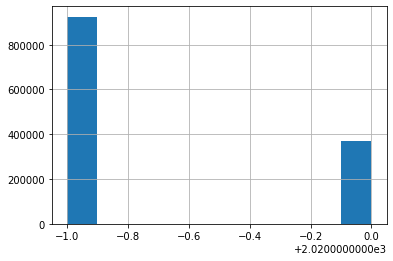

month


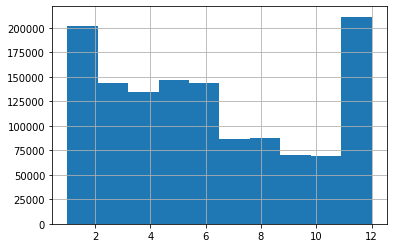

week


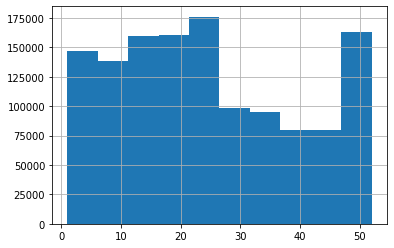

dow


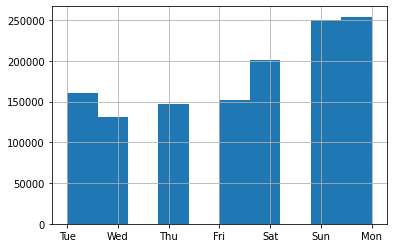

hour


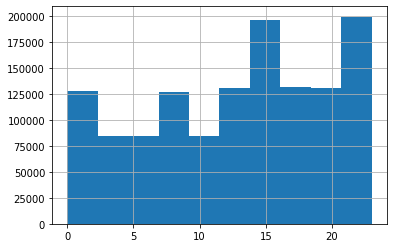

hrmin


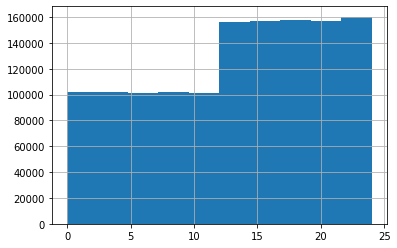

In [13]:
import matplotlib.pyplot as plt

trans = dfs['trans'].drop(columns=['cc_num','merchant'])
trans['trans_date_trans_time'] = pd.to_datetime(dfs['trans']['trans_date_trans_time'])
trans['year'] = trans['trans_date_trans_time'].dt.year
trans['month'] = trans['trans_date_trans_time'].dt.month
trans['week'] = trans['trans_date_trans_time'].dt.isocalendar().week
trans['dow'] = trans['trans_date_trans_time'].dt.day_name().str[:3]
trans['hour'] = trans['trans_date_trans_time'].dt.hour
trans['hrmin'] = (trans['hour'] + 
                  trans['trans_date_trans_time'].dt.minute/60+
                  trans['trans_date_trans_time'].dt.second/60**2)
for x in ['year','month','week','dow','hour','hrmin']:
    print(x)
    plt.show(trans[x].hist())

#### Holder variables

age


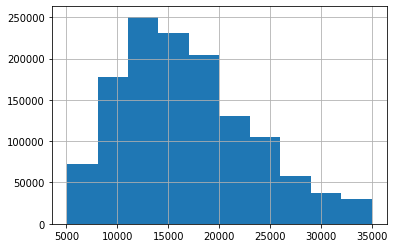

distance


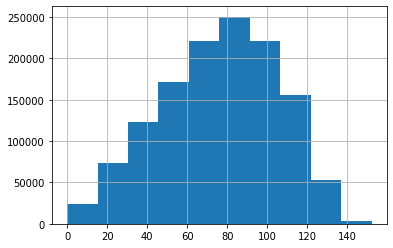

In [14]:
import mpu

df = trans.set_index('id_holder').join(holder).reset_index()
df['age'] = ((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1,'D')).astype(int)
df['distance'] = [mpu.haversine_distance((x[0],x[1]),(y[0],y[1])) for x,y in 
                  zip(zip(df['merch_lat'],df['merch_long']),zip(df['lat'],df['long']))]
for x in ['age','distance']:
    print(x)
    plt.show(df[x].hist())

## TAD

In [15]:
display(df.sample())

,id_holder,trans_num,unix_time,trans_date_trans_time,category,merch_lat,merch_long,amt,year,month,week,dow,hour,hrmin,gender,dob,lat,long,age,distance
190239,200148,12f11762efd77efac8fea5a945bb8675,1351947747,2019-11-03 13:02:27,travel,41.3490,-83.4624,1.8700,2019,11,44,Sun,13,13.0408,F,1965-09-15,41.5686,-83.3632,19772,25.7783


### Multishift

In [16]:
import seaborn as sns
color = sns.dark_palette("#69d",as_cmap=True)

multishift(df.head(1000),
           id_cols=['id_holder'],
           date_cols=['year','month'],
           shifts=range(1,6),
           aggfunc={'amt':['count',sum,'median'],
                    'distance':'mean'})[0].style.background_gradient(cmap=color).format('{:.1f}')

In [17]:
from statistics import mode

X,omitted = multishift(df,
                       id_cols=['id_holder'],
                       date_cols=['year','week'],
                       shifts=range(1,6),
                       aggfunc={'category':mode,
                                'dow':mode,
                                'age':'mean',
                                'hrmin':['mean',perc15,perc25,perc75,perc85],
                                'distance':['mean',perc15,perc25,perc75,perc85],
                                'amt':['count',sum,'mean',perc15,perc25,perc75,perc85],
                       })
print(X.shape,len(omitted))

(69839, 120) 75


In [18]:
#X.reset_index().to_csv(os.path.join(BASE_DIR,'0503_Xclustering.csv'),index=False)

### Category encoder

In [19]:
#X = pd.read_csv(os.path.join(BASE_DIR,'0503_Xclustering.csv'),index_col=[0,1])
X.dropna(inplace=True)
X.shape

(65299, 120)

In [20]:
num = X.head().describe().columns.to_list()
cat = [x for x in X.columns if x not in num]
cat

['category_mode',
 'dow_mode',
 'category_mode_01',
 'dow_mode_01',
 'category_mode_02',
 'dow_mode_02',
 'category_mode_03',
 'dow_mode_03',
 'category_mode_04',
 'dow_mode_04',
 'category_mode_05',
 'dow_mode_05']

In [21]:
from sklearn.preprocessing import LabelEncoder
encod = {}
for x in cat:
    encod[x] = LabelEncoder()
    X[x] = encod[x].fit_transform(X[x])
    
print(encod)
X[cat].sample()

{'category_mode': LabelEncoder(), 'dow_mode': LabelEncoder(), 'category_mode_01': LabelEncoder(), 'dow_mode_01': LabelEncoder(), 'category_mode_02': LabelEncoder(), 'dow_mode_02': LabelEncoder(), 'category_mode_03': LabelEncoder(), 'dow_mode_03': LabelEncoder(), 'category_mode_04': LabelEncoder(), 'dow_mode_04': LabelEncoder(), 'category_mode_05': LabelEncoder(), 'dow_mode_05': LabelEncoder()}


,,,category_mode,dow_mode,category_mode_01,dow_mode_01,category_mode_02,dow_mode_02,category_mode_03,dow_mode_03,category_mode_04,dow_mode_04,category_mode_05,dow_mode_05
id_holder,year,week,,,,,,,,,,,,
200372,2019.0000,4.0000,10,2,7,3,4,0,4,1,1,5,1,6


### Holder level

In [22]:
X_holder = X.reset_index().pivot_table(index='id_holder',
                                       columns=['year','week'],
                                       values=X.columns,
                                       fill_value=0)
X_holder.columns = ['_'.join([str(x) for x in col]) for col in X_holder.columns]
X_holder.sample()

,age_mean_2019.0_1.0,age_mean_2019.0_2.0,age_mean_2019.0_3.0,age_mean_2019.0_4.0,age_mean_2019.0_5.0,age_mean_2019.0_6.0,age_mean_2019.0_7.0,age_mean_2019.0_8.0,age_mean_2019.0_9.0,age_mean_2019.0_10.0,...,hrmin_perc85_05_2020.0_16.0,hrmin_perc85_05_2020.0_17.0,hrmin_perc85_05_2020.0_18.0,hrmin_perc85_05_2020.0_19.0,hrmin_perc85_05_2020.0_20.0,hrmin_perc85_05_2020.0_21.0,hrmin_perc85_05_2020.0_22.0,hrmin_perc85_05_2020.0_23.0,hrmin_perc85_05_2020.0_24.0,hrmin_perc85_05_2020.0_25.0
id_holder,,,,,,,,,,,,,,,,,,,,,
200563,24248.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23749.6667,23756.0000,23764.5000,23771.8750,...,20.0506,11.8778,18.6993,20.8204,18.7573,19.4741,11.7053,15.1999,19.9916,3.6750


In [23]:
X_holder.shape , holder.shape , len(omitted)

((908, 9240), (983, 4), 75)

## Clustering

### K-clusters

line_chart = koptimo(X_holder)

line_chart.render_in_browser()

### Model

for i in [4,5,8,11]:
    clustering(X_holder,X_holder.columns,n_clusters=i,kmeans=True)

Distribución de registros en los 4 clústeres


,cluster
index,
A,34.1%
B,19.6%
C,15.9%
D,30.4%


Varianza explicada con 2dim: 13.8%


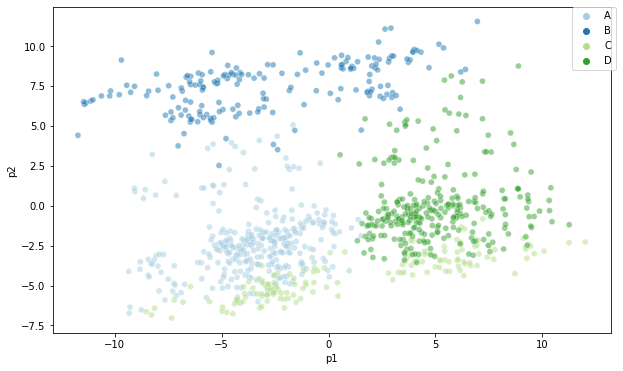

In [24]:
X_clusters = clustering(X_holder,X_holder.columns,n_clusters=4,kmeans=True)

### Diff between clusters

In [25]:
#profiles(X_clusters)

## Omitted

In [26]:
extra = df[df['id_holder'].isin(omitted)]
extra = extra.pivot_table(index='id_holder',
                          aggfunc={'category':mode,
                                   'dow':mode,
                                   'age':'mean',
                                   'hrmin':['mean',perc15,perc25,perc75,perc85],
                                   'distance':['mean',perc15,perc25,perc75,perc85],
                                   'amt':['count',sum,'mean',perc15,perc25,perc75,perc85]})
extra.columns = ['_'.join([str(x) for x in col]) for col in extra.columns]
extra['cluster'] = '00'
print(extra.shape)
extra.sample()

(75, 21)


,age_mean,amt_count,amt_mean,amt_perc15,amt_perc25,amt_perc75,amt_perc85,amt_sum,category_mode,distance_mean,...,distance_perc25,distance_perc75,distance_perc85,dow_mode,hrmin_mean,hrmin_perc15,hrmin_perc25,hrmin_perc75,hrmin_perc85,cluster
id_holder,,,,,,,,,,,,,,,,,,,,,
200491,23051.6667,9,549.3356,67.6340,299.9700,956.1900,990.9340,4944.0200,shopping_net,72.4287,...,65.0162,79.4723,89.3659,Wed,14.5206,2.6453,3.3600,23.0217,23.2074,00


In [27]:
total = X_clusters.append(extra).fillna(0)
#profiles(total)

## Fraud

In [28]:
total['cluster'].value_counts().to_frame().sort_index()

,cluster
00,75
A,310
B,178
C,144
D,276


In [29]:
fraud = pd.read_csv(os.path.join(BASE_DIR,'0503_fraud.csv'))
fraud['frauds'] = 1
fraud.set_index('trans_num',inplace=True)
fraud.sample()

,frauds
trans_num,
04edfdae840ed0862dc385c4f3f9e0ea,1


In [30]:
frauds = df.set_index('trans_num').join(fraud).merge(total['cluster'].reset_index(),
                                                     on='id_holder').fillna({'frauds':0})
frauds.sample()

,id_holder,unix_time,trans_date_trans_time,category,merch_lat,merch_long,amt,year,month,week,...,hour,hrmin,gender,dob,lat,long,age,distance,frauds,cluster
341438,200281,1359262170,2020-01-27 04:49:30,gas_transport,35.2714,-89.5840,62.6500,2020,1,5,...,4,4.8250,M,1993-03-23,35.2229,-89.5518,9806,6.1307,0.0000,B


In [31]:
summary = frauds.pivot_table(index=['id_holder','cluster'],
                             values='frauds',
                             aggfunc=[sum,'mean'],
                             fill_value=0)
summary.columns = ['_'.join(x) for x in summary.columns]
summary = summary.reset_index().set_index('id_holder')
summary.sort_values('mean_frauds',0,0).head()

,cluster,sum_frauds,mean_frauds
id_holder,,,
200375,00,10,1.0000
200285,00,8,1.0000
200104,00,12,1.0000
200651,00,13,1.0000
200179,00,9,1.0000


## Total

In [32]:
tot_frauds = summary.groupby('cluster').agg({'sum_frauds':[sum,'mean'],
                                             'mean_frauds':['mean','median']})
tot_frauds.columns = ['_'.join(x) for x in tot_frauds.columns]
tot_frauds

,sum_frauds_sum,sum_frauds_mean,mean_frauds_mean,mean_frauds_median
cluster,,,,
00,741,9.8800,1.0000,1.0000
A,2302,7.4258,0.0063,0.0049
B,1404,7.8876,0.0076,0.0059
C,1096,7.6111,0.0073,0.0060
D,1963,7.1123,0.0079,0.0068


In [33]:
final = X.reset_index().set_index('id_holder').join(summary)
prev = final.head().filter(regex='_\d{2}').columns.to_list()
actual = [x for x in final.columns if x not in prev]
len(actual)

25

In [34]:
final = final[actual].append(extra)
final['age_mean'] /= 365

In [35]:
final.groupby("cluster").mean().style.background_gradient(cmap='Blues')

,year,week,age_mean,amt_count,amt_mean,amt_perc15,amt_perc25,amt_perc75,amt_perc85,amt_sum,distance_mean,distance_perc15,distance_perc25,distance_perc75,distance_perc85,hrmin_mean,hrmin_perc15,hrmin_perc25,hrmin_perc75,hrmin_perc85,sum_frauds,mean_frauds
cluster,,,,,,,,,,,,,,,,,,,,,,
00,nan,nan,58.875499,9.880000,596.327436,223.873187,330.323567,890.628533,956.059320,5898.948133,76.406104,50.057941,58.937273,95.180043,103.210604,15.629756,5.973411,9.439514,22.613258,23.043266,nan,nan
A,2019.323523,21.824040,34.963696,21.904792,73.785206,19.038062,25.592542,88.025711,116.023695,1596.617780,76.240152,47.474561,57.888867,96.001926,104.032296,14.179628,7.341629,10.133517,18.930137,20.485620,7.426193,0.006269
B,2019.347122,22.759931,44.763083,18.511285,69.657490,15.476831,21.845991,85.279076,112.126017,1294.097884,76.250497,48.175373,58.180588,95.646982,103.466755,13.243881,6.502841,8.914393,17.984117,19.723435,7.888325,0.007634
C,2019.322222,22.952464,50.902829,19.522268,68.475483,13.083858,19.468484,85.720386,114.097165,1348.490803,75.647584,47.500347,57.472403,95.124729,103.133522,12.990080,6.172596,8.587923,17.755812,19.564415,7.609313,0.007328
D,2019.326524,21.953044,65.017179,15.216822,65.654559,10.962875,17.317608,84.361158,111.279303,1002.504803,76.049727,48.672062,58.465837,94.980694,102.692027,11.476055,4.675687,6.515381,16.303308,18.438846,7.110400,0.007869


In [69]:
aux = final[final['cluster']!='00'].copy()
for cate in ['category_mode','dow_mode']:
    aux[f'decode_{cate}'] = encod[cate].inverse_transform(aux[cate].values.tolist())
    perf_cat = aux.pivot_table(index='cluster',columns=f'decode_{cate}',values='year',aggfunc='count')
    display(perf_cat.T.style.background_gradient(cmap='Blues'))

cluster,A,B,C,D
decode_category_mode,,,,
entertainment,1249,797,583,1343
food_dining,1381,772,554,968
gas_transport,3320,2209,1978,4203
grocery_net,632,276,172,65
grocery_pos,3146,1737,1328,2537
health_fitness,1012,591,431,912
home,2697,1387,1129,2012
kids_pets,1721,1115,890,1915
misc_net,623,382,271,653


cluster,A,B,C,D
decode_dow_mode,,,,
Fri,1428,831,631,1205
Mon,7662,4513,3778,7273
Sat,3005,1782,1332,2702
Sun,5022,2666,2180,3883
Thu,1516,834,694,1319
Tue,2467,1449,1187,2328
Wed,1155,713,548,1117


## Export

In [36]:
#Save TAD
total.to_csv(os.path.join(BASE_DIR,'0503_tad.csv'),index=False)
total.shape

(983, 9261)

## End

In [37]:
time_exp(time.time() - start)
tone()

5 minutos con 2.65 segundos
